# Chicago Airbnb Data Analysis

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

## 2. Exploratory data analysis

### 2.1. Q1: How do listing information differ among different neiborhoods?

In [2]:
# Listings
listing = pd.read_csv("listings.csv.gz")

In [3]:
# Dataframe from Section 2.2.
listing21 = pd.read_csv("temp/listing13.csv")
listing21.head()

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,...,amenity_Bathtub,amenity_Smoking allowed,amenity_Exercise equipment,amenity_Wide entryway,amenity_Rain shower,amenity_Outdoor seating,amenity_Beach essentials,amenity_Disabled parking spot,amenity_Essentials,amenity_Wine cooler
0,2384,2613,2008-08-29,NaN,NaN,1,1,1,1,Hyde Park,...,0,0,0,0,0,0,0,0,1,0
1,4505,5775,2008-12-29,1.0,100.0,1,1,1,1,Little Village,...,1,0,0,0,0,0,0,0,1,0
2,6715,15365,2009-04-30,NaN,NaN,0,2,1,0,Lincoln Park,...,0,0,0,0,0,0,0,0,1,0
3,9811,33004,2009-08-21,1.0,100.0,0,8,1,1,Old Town,...,0,0,0,0,0,0,0,0,1,0
4,10610,2140,2008-08-16,1.0,100.0,0,5,1,1,Hyde Park,...,0,0,0,0,0,0,0,0,1,0


In [4]:
# Price per person
listing21['price_per_person'] = listing21['price'] / listing21['accommodates']

#### Price by neighborhood

In [5]:
# Confirm the meaning of 'price' column
tst = listing21[['price', 'weekly_price', 'monthly_price']].dropna(subset=['weekly_price', 'monthly_price'])
tst['week_ratio'] = tst['weekly_price'] / tst['price']
tst['month_ratio'] = tst['monthly_price'] / tst['price']
week_ratio = round(tst['week_ratio'].mean(), 1)
month_ratio = round(tst['month_ratio'].mean(), 1)
print(f"Weekly price is on average {week_ratio} times of 'price', \
and monthly price is on average {month_ratio} times of 'price'. \
Therefore, 'price' column should refer to daily price of a listing.")

Weekly price is on average 6.8 times of 'price', and monthly price is on average 22.1 times of 'price'. Therefore, 'price' column should refer to daily price of a listing.


Interestingly, there are many listings with > $200 price per person per night. The extremely high price listings requires closer examination.

In [6]:
# High price listings
high_price_listings = listing.copy()
high_price_listings['price_per_person'] = listing21['price_per_person']
high_price_listings = high_price_listings.loc[high_price_listings['price_per_person']>200
                       ].sort_values(by=['price_per_person'], ascending=False)[[
    'neighbourhood', 'price_per_person', 'price', 'weekly_price', 'monthly_price', 'number_of_reviews', 'description',
    'minimum_nights', 'notes', 'property_type', 'room_type', 'accommodates', 'bathrooms',
    'bedrooms', 'beds', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
    'first_review', 'review_scores_rating'
]]

high_price_no_review = high_price_listings.loc[high_price_listings['number_of_reviews']==0].shape[0]
high_price = high_price_listings.shape[0]
print(f"There are {high_price} listings that have price per person > $200, \
of which {high_price_no_review} have no reviews to date.")

There are 54 listings that have price per person > $200, of which 21 have no reviews to date.


These high price listings with no reviews could be outliers that are not useful in training a model that predicts price. So I will drop these rows before the machine learning step.

In [7]:
# High price listings with at least 1 review
high_price_listings.loc[high_price_listings['number_of_reviews']>0].head()

,neighbourhood,price_per_person,price,weekly_price,monthly_price,number_of_reviews,description,minimum_nights,notes,property_type,...,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,first_review,review_scores_rating
3512,Lakeview,9999.0,"$9,999.00",NaN,NaN,2,Large room with private bathroom in a 2 bedroo...,80,NaN,Apartment,...,1,1.0,0,1.0,$0.00,$30.00,1,$0.00,2017-07-31,90.0
300,Andersonville,2068.5,"$4,137.00",$375.00,"$1,500.00",214,Located in the Andersonville area with lots of...,2,INQUIRING GUESTS PLEASE NOTE: I would be happy...,House,...,2,1.0,1,1.0,NaN,NaN,2,$0.00,2014-05-21,96.0
443,Lakeview,500.0,"$1,000.00",$533.00,"$1,953.00",19,This is a perfect place to stay for a short ti...,2,NaN,Apartment,...,2,1.0,1,1.0,$200.00,$100.00,1,$0.00,2015-06-15,91.0
3549,Little Village,500.0,"$1,000.00",NaN,NaN,25,"This is a clean, comfy & kind safe accommodati...",4,-Standard Check-In 4 pm to 10 pm. -Standard C...,Apartment,...,2,1.0,1,1.0,$200.00,$18.00,1,$7.00,2017-11-12,95.0
3132,Portage Park,500.0,"$1,000.00",NaN,NaN,1,NaN,1,NaN,Apartment,...,2,1.0,1,1.0,NaN,NaN,1,$0.00,2018-09-29,NaN


It seems that some of the listings (e.g. listing in the 2nd and 3rd row above) put wrong information into the `price` column, which will bias the predictive model. Therefore, I will drop the high price per person listings unless the `price` < `weekly_price` or `price` < 1/4`monthly_price`.

In [8]:
# Drop >$1000 price unless price is reasonable compared to weekly or monthly price
listing21 = listing21.loc[((listing21['price_per_person']>=200) & 
                           (listing21['weekly_price'].notna()) & 
                           (listing21['weekly_price'] > listing21['price'])) |
                          ((listing21['price_per_person']>=200) & 
                           (listing21['monthly_price'].notna()) & 
                           (listing21['monthly_price'] > 4*listing21['price'])) |
                          (listing21['price_per_person']<200)
                         ]

# ANOVA price per person
model1 = smf.ols(formula='price_per_person ~ C(neighbourhood)', data=listing21).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:       price_per_person   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     21.21
Date:                Sat, 01 Dec 2018   Prob (F-statistic):          1.83e-284
Time:                        14:42:06   Log-Likelihood:                -32403.
No. Observations:                7263   AIC:                         6.498e+04
Df Residuals:                    7176   BIC:                         6.558e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

After excluding these high per person price listings, the relationsihp between neighbourhood and per person price is statistically significantly. An analysis of variance (ANOVA) revealed that listings in different neighbourhoods have significantly different price per perspn, with F=21.21, p<0.0001, meaning that different neighbourhood and per person price are significantly associated.

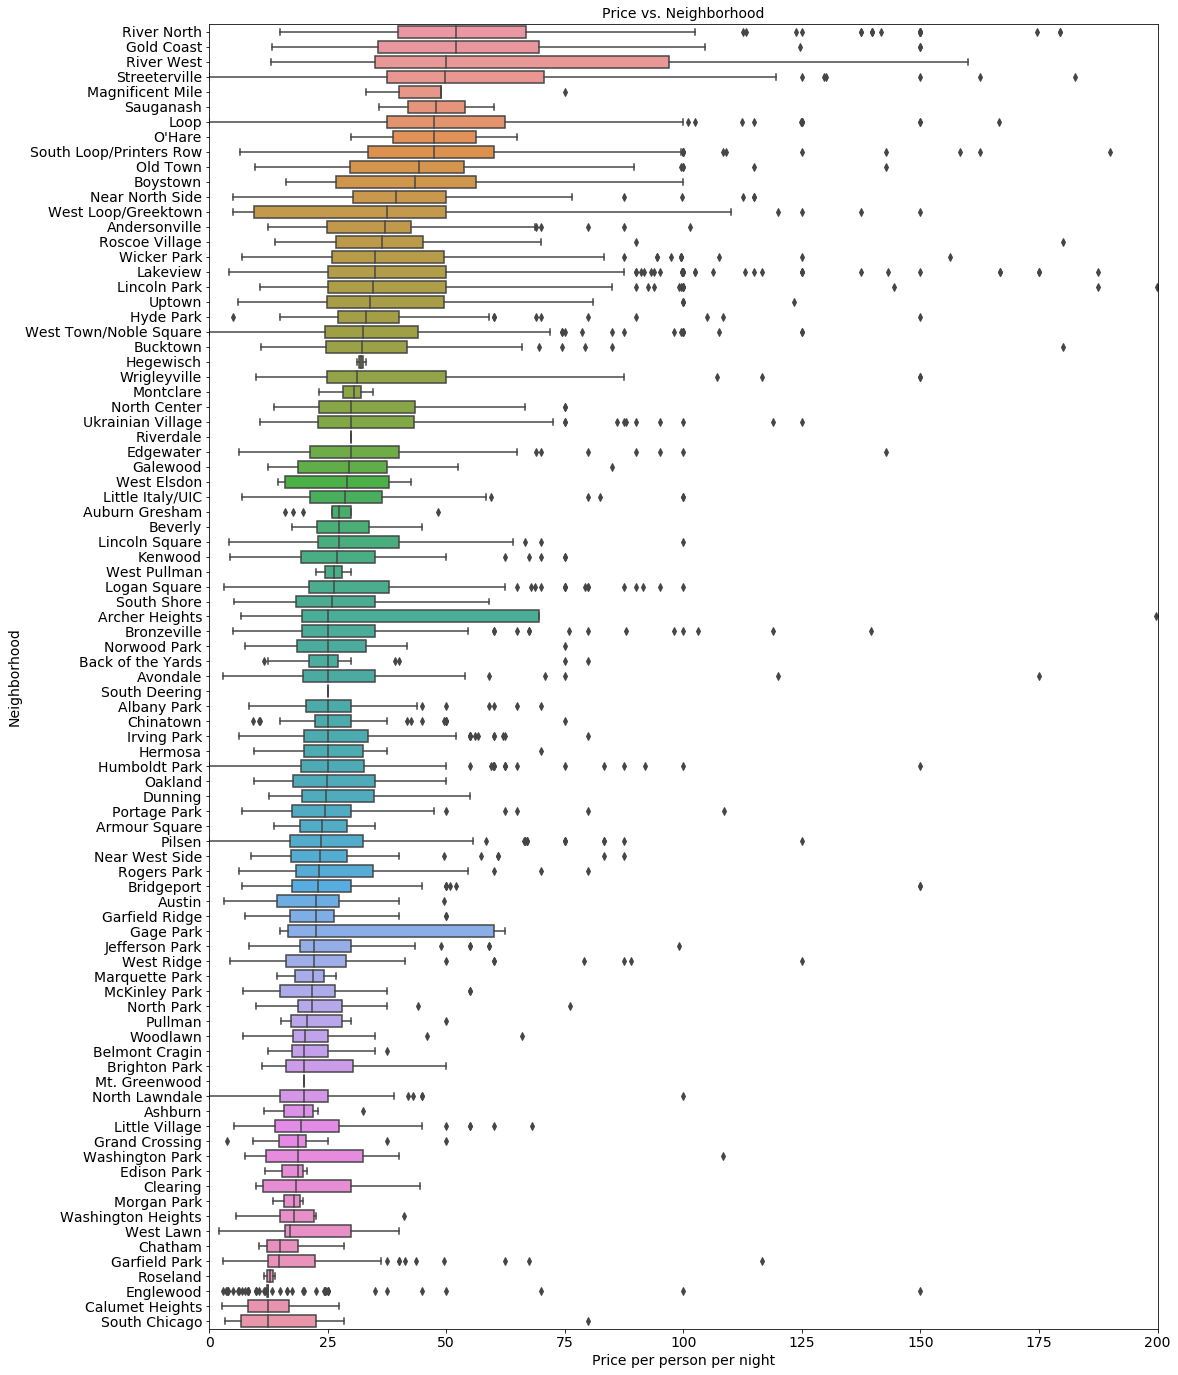

In [9]:
# Median price by neighborhood
med_price_by_nb = listing21[['neighbourhood', 'price_per_person']
         ].groupby(by=['neighbourhood']).median().sort_values(by=['price_per_person'], ascending=False)

# Boxplot of listing price by neighborhood
fig = plt.figure(figsize = (17, 24))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x="price_per_person", y="neighbourhood", data=listing21, orient='h', ax=ax, order=med_price_by_nb.index)
plt.xlim([0, 200])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Price per person per night', fontsize=14)
plt.ylabel('Neighborhood', fontsize=14)
plt.title('Price vs. Neighborhood', fontsize=14);
plt.savefig("figures/price_by_neighborhood.png");

In [10]:
# # Figure for blogging
# # Median price by neighborhood
# med_price_by_nb = listing21[['neighbourhood', 'price_per_person']
#          ].groupby(by=['neighbourhood']).median().sort_values(by=['price_per_person'], ascending=False)

# # Boxplot of listing price by neighborhood
# fontsize = 20
# fig = plt.figure(figsize = (10, 40))
# ax = fig.add_subplot(1, 1, 1)
# sns.boxplot(x="price_per_person", y="neighbourhood", data=listing21, orient='h', ax=ax, order=med_price_by_nb.index)
# plt.xlim([0, 200])
# plt.xticks(fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
# plt.xlabel('Price per person per night', fontsize=fontsize)
# plt.ylabel('Neighborhood', fontsize=fontsize)
# plt.title('Price vs. Neighborhood', fontsize=fontsize);
# plt.savefig("figures/price_by_neighborhood_post.png", bbox_inches='tight');

#### Descriptions by neighborhood

In [11]:
# Combine descriptive sentences for each listing
description = listing[['id', 'name', 'space', 'description', 'neighborhood_overview', 'neighbourhood']]
description = description.dropna(subset=['neighbourhood']).fillna('')
description['descriptive_words'] = description.apply(lambda x: f"{x['name']} {x['space']} \
{x['description']} {x['neighborhood_overview']} ", axis=1)
description = description[['descriptive_words', 'neighbourhood']]

# Combine descriptive sentences for each neighborhood
description_nb = description.groupby(by=['neighbourhood'])['descriptive_words'].sum()

In [12]:
# Tf-idf of descriptive words for each neighborhood
corpus = description_nb
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
X = vectorizer.fit_transform(corpus)

In [13]:
# Top word(s) based on tf-idf of each neighborhood
# Neiborhood names and the word 'chicago' is excluded from the list
n = 4
feature_array = np.array(vectorizer.get_feature_names())

print(f"Top {n} phrases that characterize each neighborhood:\n")
for i, nb in enumerate(description_nb.index):
    response = X[i]
    tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
    feature_array_sorted = [word for word in feature_array[tfidf_sorting] 
                            if (word not in nb.lower().replace('/', ' ').split()) and
                            (word not in nb.lower().split('/')) and
                            (word != 'chicago')
                           ]
    top_n = feature_array_sorted[:n]
    print(f"{nb}: {', '.join(top_n)}")

Top 4 phrases that characterize each neighborhood:

Albany Park: brown line, room, brown, apartment
Andersonville: room, neighborhood, restaurants, clark
Archer Heights: midway, midway international, close, close midway
Armour Square: chinatown, mccormick, downtown, sox
Ashburn: basement, home, safe police, located
Auburn Gresham: major expressways, travelers self, water pets, expressways home
Austin: oak park, oak, park, room
Avondale: logan, logan square, square, room
Back of the Yards: stone mosaic, remodeled bedrooms, furniture mattresses, mosaic hardwood
Belmont Cragin: room, bedroom, mini kitchen, kitchen
Beverly: room, city, beverly south, beverly neighborhood
Boystown: lakeview, halsted, wrigley, inn
Bridgeport: room, bed, downtown, mccormick
Brighton Park: place, midway, apartment, minutes
Bronzeville: mccormick, mccormick place, place, downtown
Bucktown: wicker, wicker park, park, apartment
Calumet Heights: cozinha, salas, mansion shared, quarto
Chatham: room, comes cozy, pro

In many neighborhoods, the most characterizing phrases are places of interests that are characteristic of the neighborhood, e.g., wrigley field for neighborhood Wrigleyvill, hancock tower for neighborhood Magnificent Mile.

Characteristic phrases in top 7 expensive neighborhoods:

- River North: room, pool, bedroom, michigan
- Gold Coast: oak street, beach, street, michigan
- River West: 747, blue line, silverware dinnerware, blue
- Streeterville: michigan, views, navy pier, pier
- Magnificent Mile: tower, hancock tower, walk, minute
- Sauganash: house, documentaries, shooting, tudor
- Loop: park, apartment, city, michigan

### 2.2. Q2: Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Chicago?

#### Housing demand 

In [14]:
# Reviews summary
review_summary = pd.read_csv("reviews.csv")
print("Review summay table:")
print(f"rows, cols: {review_summary.shape}")
review_summary.head()

Review summay table:
rows, cols: (259883, 2)


,listing_id,date
0,2384,2015-01-09
1,2384,2015-03-24
2,2384,2015-04-19
3,2384,2015-04-30
4,2384,2015-05-04


In [15]:
# Convert review date to datetime
review_summary['date'] = pd.to_datetime(review_summary['date'], format='%Y-%m-%d')

In [16]:
# Use the number of reviews as a proxy for the housing demand
review_count = review_summary.groupby(by=['date']).count().rename(columns={'listing_id': 'visitors_count'})
review_count.to_csv("temp/review_count.csv", index=False)
review_count_monthly = review_count.resample('M').sum()

#### Housing supply

In [17]:
# Use host_since and the corresponding listings as a proxy for the number of new listing at a given time
listing21['host_since'] = pd.to_datetime(listing21['host_since'], format='%Y-%m-%d')
new_listing_count = listing21.groupby(by=['host_since'])[['id']].count().rename(columns={'id': 'new_listings_count'})
new_listing_count.to_csv("temp/new_listing_count.csv", index=False)
new_listing_count_monthly = new_listing_count.resample('M').sum()

# The cumulated sum of the number of new listings over time is hence a proxy for the housing supply
listing_count_monthly = new_listing_count_monthly.cumsum().rename(columns={'new_listings_count': 'listings_count'})

In [18]:
# Merge demand and supply into one dataframe
demand_supply = review_count_monthly.merge(listing_count_monthly, how="outer", left_index=True, right_index=True)

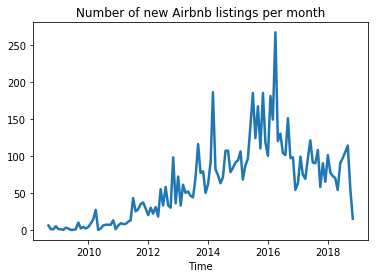

In [19]:
# Trend of new listings over time
sns.lineplot(data=new_listing_count_monthly, palette="tab10", linewidth=2.5)
plt.xlabel('Time')
plt.title('Number of new Airbnb listings per month')
plt.legend().set_visible(False)
plt.savefig('figures/new_listings_over_time.png')

Overall, the number of new listings increases steadily until around 2016, after which the number starts to decrease. However, this observation depends on the assumption that each host list his/her listings all at once, as the exact listing date was not available. This observed trend is expected to change if some of the hosts list their listings incrementally over time.

#### Supply and demand over time

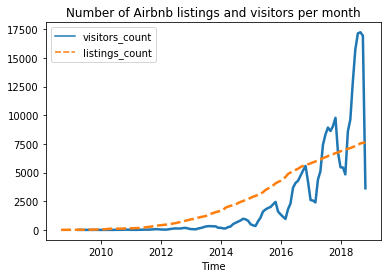

In [20]:
# Trend of monthly supply and demand over time
sns.lineplot(data=demand_supply, palette="tab10", linewidth=2.5)
plt.xlabel('Time')
plt.title('Number of Airbnb listings and visitors per month')
plt.savefig('figures/demand_supply.png')

In [21]:
# # Trend of monthly supply and demand over time
# fontsize = 16
# fig = plt.figure(figsize = (8, 5))
# ax = fig.add_subplot(1, 1, 1)
# sns.lineplot(data=demand_supply, palette="tab10", linewidth=2.5, ax=ax)
# plt.xlabel('Time', fontsize=fontsize)
# plt.title('Number of Airbnb listings and visitors per month', fontsize=fontsize)
# plt.xticks(fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
# plt.legend(['visitors', 'listings'], fontsize=fontsize)
# plt.savefig('figures/demand_supply_post.png', bbox_inches='tight')

The number of Airbnb listings and the number of Airbnb visitors both increase over time. The number of listings has a relatively steady increase over time, compared to the strong seasonal pattern in the number of visitors. Briefly, the number of visitors is highest in summer and lowest in winter, which makes sense given the brutal winter in Chicago. Note that this analysis tends to underestimate the number of visitors, because I used the number of reviews as a proxy for the number of visitors, which overlooks visitors who did not leave a review. This conservative estimation and the seasonal cycles in the number of visitors suggest that summer would be a good time to expand Airbnb market in Chicago.

#### Test significance of increase

Visitors count seems increases exponentially (both the overall trend and the cycles), so I used log transformation to normalize it.

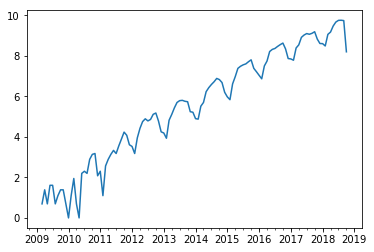

In [22]:
# Normalize 
np.log(demand_supply['visitors_count']).plot()

The trend looks more linear now, and the cycles seem stabilized too. I then use linear regression to test the significance of the overall increase.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     2313.
Date:                Sat, 01 Dec 2018   Prob (F-statistic):           1.49e-77
Time:                        14:42:56   Log-Likelihood:                -103.14
No. Observations:                 116   AIC:                             210.3
Df Residuals:                     114   BIC:                             215.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6386.8663    132.906    -48.056      0.0

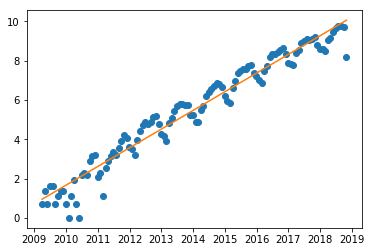

In [23]:
# Linear regression
y = np.log(demand_supply[['visitors_count']].dropna()).values
x = np.arange(y.shape[0])
x = np.array(demand_supply[['visitors_count']].dropna().index.to_julian_date())
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
trend = results.params

# Sanity check
plt.plot(demand_supply[['visitors_count']].dropna().index,y,'o')
plt.plot(demand_supply[['visitors_count']].dropna().index,trend[0]+trend[1]*x)

# Summary statistics
print(results.summary())

Regression analysis shows a strong, positive relationship between the logarithm of the number of visitors and time (p<0.001), suggesting that the upward trend in the number of visitors is statistically significant.

### 2.3. Q3: What are the busiest times of a year to visit Chicago? By how much do prices spike?

#### Number of visitors over the year

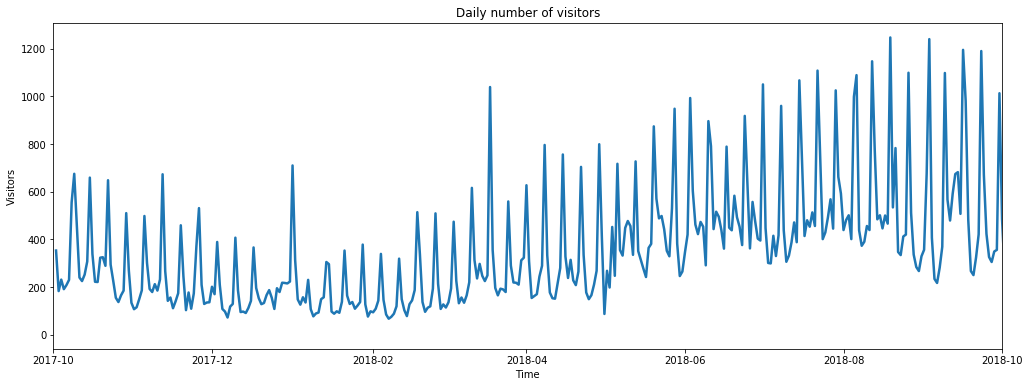

In [24]:
# Use daily number of reviews as a proxy for daily demand
daily_demand = review_count.loc[(review_count.index > datetime.datetime(2017, 10, 1))]

# Trend of daily visitors over time
fig = plt.figure(figsize = (17, 6))
ax = fig.add_subplot(1, 1, 1)
sns.lineplot(data=daily_demand, palette="tab10", linewidth=2.5, ax=ax)
plt.xlabel('Time')
plt.ylabel('Visitors')
plt.title('Daily number of visitors')
plt.legend().set_visible(False)
plt.xlim(datetime.datetime(2017, 10, 1), datetime.datetime(2018, 10, 1))
plt.savefig('figures/demand_over_time.png')

In [25]:
# The first peak corresponds to New Year's Day
daily_demand['weekday'] = daily_demand.index.weekday
daily_demand.loc[(daily_demand.index.month.isin([1,12])) 
                 & (daily_demand['visitors_count'] > 600)]

# The second peak corresponds to St Patrick's Day
daily_demand.loc[(daily_demand.index.month == 3)
                 & (daily_demand['visitors_count'] > 900)]

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,visitors_count,weekday
date,,
2018-03-18,1039,6


In [26]:
# # Trend of daily visitors over time
# daily_demand = review_count.loc[(review_count.index > datetime.datetime(2017, 10, 1))]
# fontsize = 24
# fig = plt.figure(figsize = (17, 6))
# ax = fig.add_subplot(1, 1, 1)
# sns.lineplot(data=daily_demand, palette="tab10", linewidth=2.5, ax=ax)
# plt.xlabel('Time', fontsize=fontsize)
# plt.ylabel('Visitors', fontsize=fontsize)
# plt.title('Daily number of visitors', fontsize=fontsize)
# plt.xticks(fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
# plt.legend().set_visible(False)
# plt.xlim(datetime.datetime(2017, 10, 1), datetime.datetime(2018, 10, 1))
# plt.savefig('figures/demand_over_time_post.png', bbox_inches='tight')

The number of visitors appears to have strong weekly and monthly patterns. Also note the peaks in holidays. To see whether the weekly and monthly trends are statistically significant, I used ANOVA to compare the number of visitors in different weekdays and different months.

#### Number of visitors vs. weekday

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


ANOVA on weekdays
                            OLS Regression Results                            
Dep. Variable:         visitors_count   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     40.05
Date:                Sat, 01 Dec 2018   Prob (F-statistic):           1.88e-37
Time:                        14:42:57   Log-Likelihood:                -2500.2
No. Observations:                 375   AIC:                             5014.
Df Residuals:                     368   BIC:                             5042.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         445.42

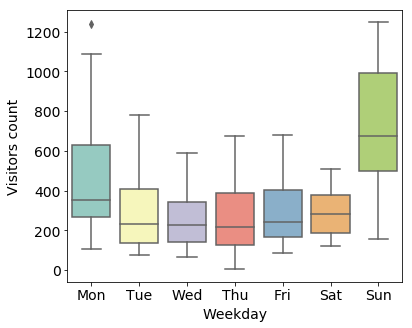

In [27]:
# Examine weekly trend
daily_demand['weekday'] = daily_demand.index.weekday

# Weekday ANOVA test
model1 = smf.ols(formula='visitors_count ~ C(weekday)', data=daily_demand).fit()
print("ANOVA on weekdays")
print (model1.summary())

# Weekday plot
fig = plt.figure(figsize = (6, 5))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x="weekday", y="visitors_count", data=daily_demand, ax=ax, palette='Set3')
plt.xlabel('Weekday', fontsize=14)
plt.ylabel('Visitors count', fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=14)
plt.yticks(fontsize=14);

The ANOVA test shows that some of the weekdays are significantly different from others. Tukey's Honestly Significant Difference Test (post hoc test) was applied to evaluate the difference between each pair of weekdays.

In [28]:
# Weekday post hoc test
mc1 = multi.MultiComparison(daily_demand['visitors_count'], daily_demand['weekday'])
res1 = mc1.tukeyhsd()
print(res1.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower    upper   reject
-------------------------------------------------
  0      1    -173.5741 -283.1331 -64.0151  True 
  0      2    -189.8333 -299.3924 -80.2743  True 
  0      3    -193.7963 -303.3553 -84.2373  True 
  0      4    -161.6146 -271.6892  -51.54   True 
  0      5     -159.841 -269.9156 -49.7664  True 
  0      6     257.3854  147.3108  367.46   True 
  1      2     -16.2593 -125.8183 93.2998  False 
  1      3     -20.2222 -129.7812 89.3368  False 
  1      4     11.9595   -98.1151 122.0341 False 
  1      5     13.7331   -96.3415 123.8076 False 
  1      6     430.9595  320.8849 541.0341  True 
  2      3      -3.963   -113.522 105.5961 False 
  2      4     28.2187   -81.8559 138.2933 False 
  2      5     29.9923   -80.0823 140.0669 False 
  2      6     447.2187  337.1441 557.2933  True 
  3      4     32.1817   -77.8929 142.2563 False 
  3      5     33.9553   -76.1193 144.0299 False 

The post hoc test, combined with the boxplot, shows that the number of visitors on Monday and Sunday are significantly higher from the number of visitors in other weekdays.

#### Number of visitors vs. month

ANOVA on months
                            OLS Regression Results                            
Dep. Variable:         visitors_count   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     20.03
Date:                Sat, 01 Dec 2018   Prob (F-statistic):           1.59e-31
Time:                        14:42:57   Log-Likelihood:                -2505.5
No. Observations:                 375   AIC:                             5035.
Df Residuals:                     363   BIC:                             5082.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        175.3226   

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


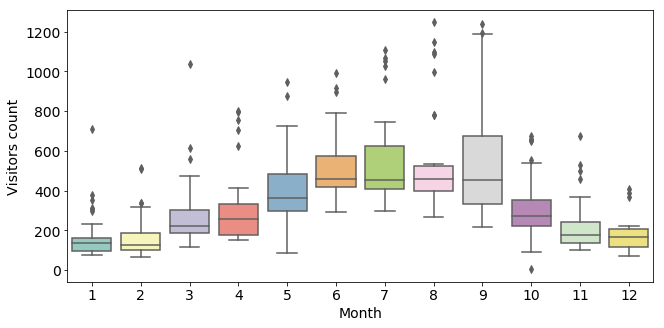

In [29]:
# Examine monthly trend
daily_demand['month'] = daily_demand.index.month

# Month ANOVA test
model2 = smf.ols(formula='visitors_count ~ C(month)', data=daily_demand).fit()
print("ANOVA on months")
print (model2.summary())

# Month plot
fig = plt.figure(figsize = (10.5, 5))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x="month", y="visitors_count", data=daily_demand, ax=ax, palette='Set3')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Visitors count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

The ANOVA test shows that some of the months are significantly different from others. Tukey's Honestly Significant Difference Test (post hoc test) was applied to evaluate the difference between each pair of months.

In [30]:
# Month post hoc test
mc2 = multi.MultiComparison(daily_demand['visitors_count'], daily_demand['month'])
res2 = mc2.tukeyhsd()
print(res2.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower     upper   reject
--------------------------------------------------
  1      2     -2.4654  -170.6434  165.7125 False 
  1      3     101.5161  -62.3303  265.3626 False 
  1      4     145.2774  -19.9288  310.4836 False 
  1      5     242.5484  78.7019   406.3949  True 
  1      6     349.0774  183.8712  514.2836  True 
  1      7     377.2903  213.4439  541.1368  True 
  1      8     380.5161  216.6697  544.3626  True 
  1      9     389.0441  223.8379  554.2503  True 
  1      10    137.7994  -15.7317  291.3305 False 
  1      11    51.2108  -113.9955  216.417  False 
  1      12     0.871   -162.9755  164.7174 False 
  2      3     103.9816  -64.1964  272.1595 False 
  2      4     147.7429  -21.7601  317.2458 False 
  2      5     245.0138  76.8359   413.1918  True 
  2      6     351.5429  182.0399  521.0458  True 
  2      7     379.7558  211.5778  547.9337  True 
  2      8     382.9816  214.80

The post hoc test, combined with the boxplot, shows that the number of visitors in June-September are significantly higher from the number of visitors in January-April and in October-December.

**To summarize, the busiest time to visit Chicago are June-September, especially on Sunday and Monday.**

#### Listing price over the year

Calendar table:
rows, cols: (2798090, 4)


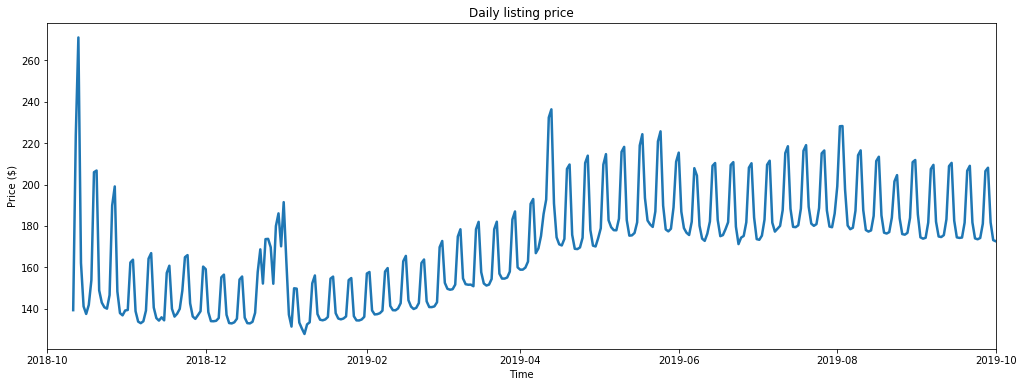

In [31]:
# Calendar table, where daily listing price is availabel for the next 12 months
calendar = pd.read_csv("data/calendar.csv.gz")
print("Calendar table:")
print(f"rows, cols: {calendar.shape}")
# calendar.head()

# Convert data types
calendar['date'] = pd.to_datetime(calendar['date'], format='%Y-%m-%d')
calendar['price'] = calendar['price'].str.strip('$').str.replace(',', '').astype('float')

# Calculate average listing price by date
calendar.index = calendar['date']
daily_price = calendar[['price']].resample('D').mean()
# daily_price.head()

# Trend of mean daily listing price over time
fig = plt.figure(figsize = (17, 6))
ax = fig.add_subplot(1, 1, 1)
sns.lineplot(data=daily_price, palette="tab10", linewidth=2.5, ax=ax)
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.title('Daily listing price')
plt.legend().set_visible(False)
plt.xlim(datetime.datetime(2018, 10, 1), datetime.datetime(2019, 10, 1))
plt.savefig('figures/price_over_time.png')

The daily listing price also appears to have strong weekly and monthly patterns. Note that the price in the near future, Oct 2018 - Nov 2018, has huge fluctuations, which is likely due to the fact that most of the near-future listings are already not available so the near-future prices are biased. Price near the end of the year is also consistently higher. In order to see how much the listing price spikes, I'm going to compare the average of daily listing price in terms of weekdays and months.

In [32]:
daily_price['weekday'] = daily_price.index.weekday
daily_price['month'] = daily_price.index.month

# Compare weekdays
print("Mean daily price for each weekday:")
weekday_price = daily_price.groupby(by=['weekday'])[['price']].mean()
weekday_price.rename(index=dict(zip(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])))

Mean daily price for each weekday:


,price
weekday,
Mon,160.261652
Tue,159.274291
Wed,159.942498
Thu,164.027547
Fri,190.742572
Sat,194.153031
Sun,165.700473


In general, Tuesday has the lowest price (\$159), and Saturday has the highest price (\$194). Weekday average of daily price fluctuates by ~$35.

In [33]:
# Compare months
print("Mean daily price for each month:")
monthly_price = daily_price.groupby(by=['month'])[['price']].mean()
monthly_price

Mean daily price for each month:


,price
month,
1,140.289624
2,146.350093
3,161.478283
4,182.688514
5,191.675472
6,187.699754
7,190.335472
8,192.361458
9,185.778908


In general, January has the lowest price (\$140), and August has the highest price (\$192). Monthly average of daily price fluctuates by ~\$52.

In [34]:
# Save checkpoint
listing21.to_csv("temp/listing21.csv", index=False)

To be continued in `model.ipynb`